# ШАГ 1: ИМПОРТ БИБЛИОТЕК И ЗАГРУЗКА ДАННЫХ

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import joblib
import warnings
import shap
from sklearn.inspection import PartialDependenceDisplay
warnings.filterwarnings('ignore')

# Создаем словарь для переименования

In [4]:
df = pd.read_csv('brfss_2015_cleaned.csv')

# Переименовываем колонки
rename_dict = {
    '_MICHD': 'HeartDiseaseorAttack',
    '_RFHYPE5': 'HighBP',
    'TOLDHI2': 'HighChol',
    '_CHOLCHK': 'CholCheck',
    '_BMI5': 'BMI',
    'SMOKE100': 'Smoker',
    'CVDSTRK3': 'Stroke',
    'DIABETE3': 'Diabetes',
    '_TOTINDA': 'PhysActivity',
    '_FRTLT1': 'Fruits',
    '_VEGLT1': 'Veggies',
    '_RFDRHV5': 'HvyAlcoholConsump',
    'HLTHPLN1': 'AnyHealthcare',
    'MEDCOST': 'NoDocbcCost',
    'GENHLTH': 'GenHlth',
    'MENTHLTH': 'MentHlth',
    'PHYSHLTH': 'PhysHlth',
    'DIFFWALK': 'DiffWalk',
    'SEX': 'Sex',
    '_AGEG5YR': 'Age',
    'EDUCA': 'Education',
    'INCOME2': 'Income'
}

df = df.rename(columns=rename_dict)

In [5]:
print(" Размер датасета:", df.shape)
print("\n Первые 5 строк:")
print(df.head())
print("\n Распределение целевой переменной (HeartDiseaseorAttack):")
print(df['HeartDiseaseorAttack'].value_counts())
print("Процент случаев болезни:", round(df['HeartDiseaseorAttack'].mean()*100, 2), "%")

 Размер датасета: (294102, 22)

 Первые 5 строк:
   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.0     1.0  ...            1.0          0.0      2.0   

   Ment

ШАГ 2: РАЗВЕДОЧНЫЙ АНАЛИЗ (EDA) 

In [6]:
print("📊 ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ:")
print(df.info())

# Проверим пропущенные значения
print("\n🔍 ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Если пропусков нет, продолжаем анализ
# Корреляция с целевой переменной
print("\n📈 КОРРЕЛЯЦИЯ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (HeartDiseaseorAttack):")
correlations = df.corr()['HeartDiseaseorAttack'].sort_values(ascending=False)
print(correlations.head(15))  # Топ-15 факторов


📊 ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294102 entries, 0 to 294101
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  294102 non-null  float64
 1   HighBP                294102 non-null  float64
 2   HighChol              294102 non-null  float64
 3   CholCheck             294102 non-null  float64
 4   BMI                   294102 non-null  float64
 5   Smoker                294102 non-null  float64
 6   Stroke                294102 non-null  float64
 7   Diabetes              294102 non-null  float64
 8   PhysActivity          294102 non-null  float64
 9   Fruits                294102 non-null  float64
 10  Veggies               294102 non-null  float64
 11  HvyAlcoholConsump     294102 non-null  float64
 12  AnyHealthcare         294102 non-null  float64
 13  NoDocbcCost           294102 non-null  float64
 14  GenHlth             

 Визуализация топ-10 корреляций

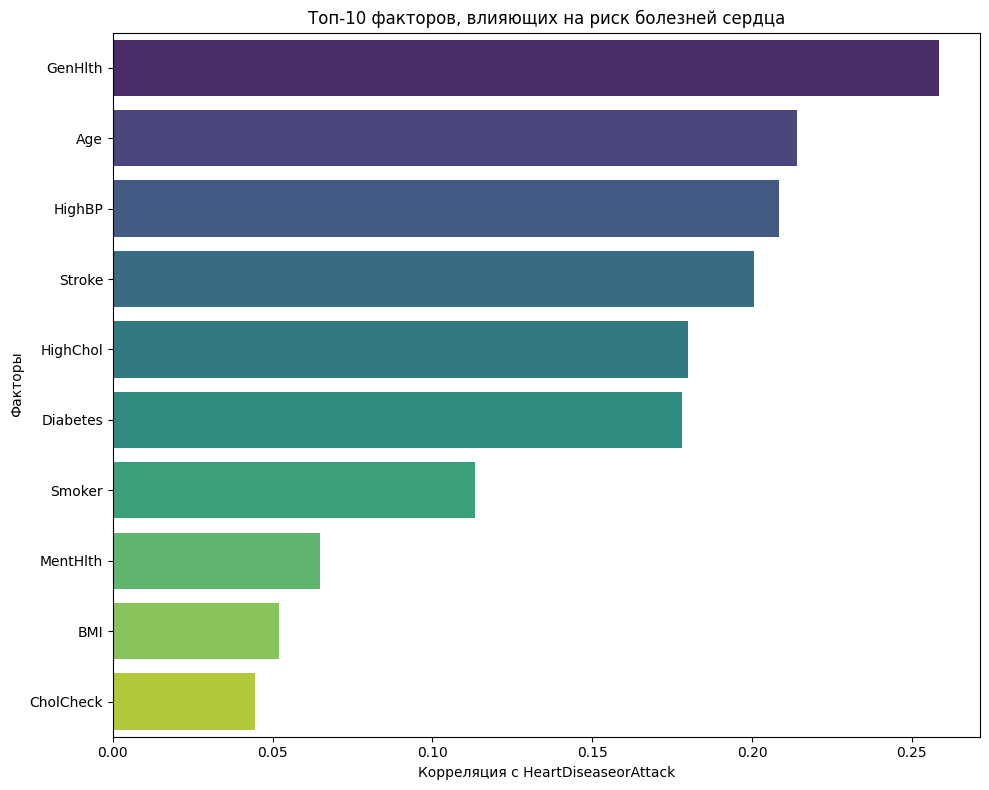

In [7]:
plt.figure(figsize=(10, 8))
top_features = correlations.index[1:11]  # Без самой целевой
top_correlations = correlations.values[1:11]

sns.barplot(x=top_correlations, y=top_features, palette='viridis')
plt.title('Топ-10 факторов, влияющих на риск болезней сердца')
plt.xlabel('Корреляция с HeartDiseaseorAttack')
plt.ylabel('Факторы')
plt.tight_layout()
plt.show()


Анализ дисбаланса классов

In [8]:
print(f"\n⚖️ ДИСБАЛАНС КЛАССОВ:")
print(df['HeartDiseaseorAttack'].value_counts())
print(f"Соотношение классов: {df['HeartDiseaseorAttack'].value_counts(normalize=True)}")



⚖️ ДИСБАЛАНС КЛАССОВ:
HeartDiseaseorAttack
0.0    265640
1.0     28462
Name: count, dtype: int64
Соотношение классов: HeartDiseaseorAttack
0.0    0.903224
1.0    0.096776
Name: proportion, dtype: float64


Визуализация распределения классов

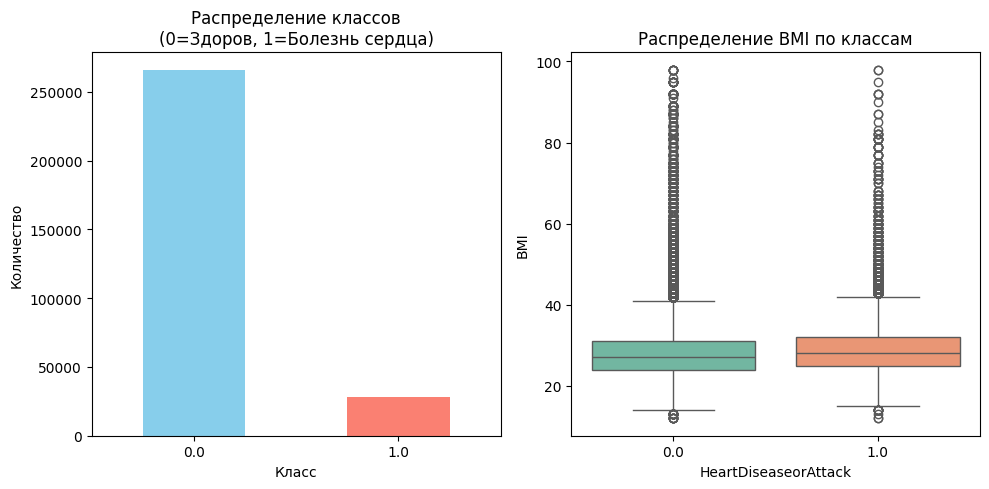

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['HeartDiseaseorAttack'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение классов\n(0=Здоров, 1=Болезнь сердца)')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
sns.boxplot(x='HeartDiseaseorAttack', y='BMI', data=df, palette='Set2')
plt.title('Распределение BMI по классам')
plt.tight_layout()
plt.show()

Анализ возраста (преобразуем из категорий в числовое значение)

In [10]:
print("\n👴 РАСПРЕДЕЛЕНИЕ ВОЗРАСТА:")
print(df['Age'].value_counts().sort_index())


👴 РАСПРЕДЕЛЕНИЕ ВОЗРАСТА:
Age
1.0      7106
2.0      8394
3.0     12000
4.0     14955
5.0     17486
6.0     21600
7.0     29138
8.0     34572
9.0     37905
10.0    37811
11.0    28582
12.0    20095
13.0    22974
14.0     1484
Name: count, dtype: int64


В данных BRFSS возраст закодирован категориями:

1 = 18-24 лет

2 = 25-29 лет

3 = 30-34 лет

4 = 35-39 лет

5 = 40-44 лет

6 = 45-49 лет

7 = 50-54 лет

8 = 55-59 лет

9 = 60-64 лет

10 = 65-69 лет

11 = 70-74 лет

12 = 75-79 лет

13 = 80+ лет

14 = Отказ отвечать / Неизвестно

# Визуализация возраста и болезни сердца

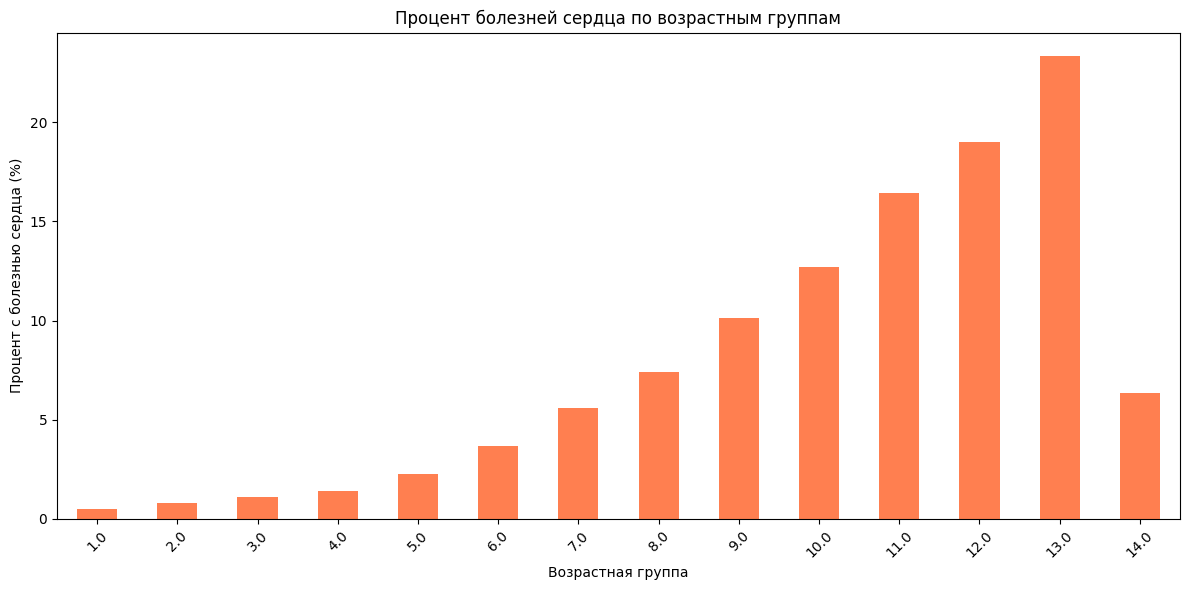

In [16]:
plt.figure(figsize=(12, 6))
age_sick_rate = df.groupby('Age')['HeartDiseaseorAttack'].mean() * 100
age_sick_rate.plot(kind='bar', color='coral')
plt.title('Процент болезней сердца по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Процент с болезнью сердца (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1. Удаляем строки с Age = 14 

In [17]:
print(f"До удаления Age=14: {df.shape}")
df_cleaned = df[df['Age'] != 14].copy()
print(f"После удаления Age=14: {df_cleaned.shape}")
print(f"Удалено {len(df) - len(df_cleaned)} строк")

До удаления Age=14: (294102, 22)
После удаления Age=14: (292618, 22)
Удалено 1484 строк


In [18]:
age_mapping = {
    1.0: 21,   # 18-24 → 21
    2.0: 27,   # 25-29 → 27
    3.0: 32,   # 30-34 → 32
    4.0: 37,   # 35-39 → 37
    5.0: 42,   # 40-44 → 42
    6.0: 47,   # 45-49 → 47
    7.0: 52,   # 50-54 → 52
    8.0: 57,   # 55-59 → 57
    9.0: 62,   # 60-64 → 62
    10.0: 67,  # 65-69 → 67
    11.0: 72,  # 70-74 → 72
    12.0: 77,  # 75-79 → 77
    13.0: 82   # 80+ → 82
}

df_cleaned['Age_Numeric'] = df_cleaned['Age'].map(age_mapping)


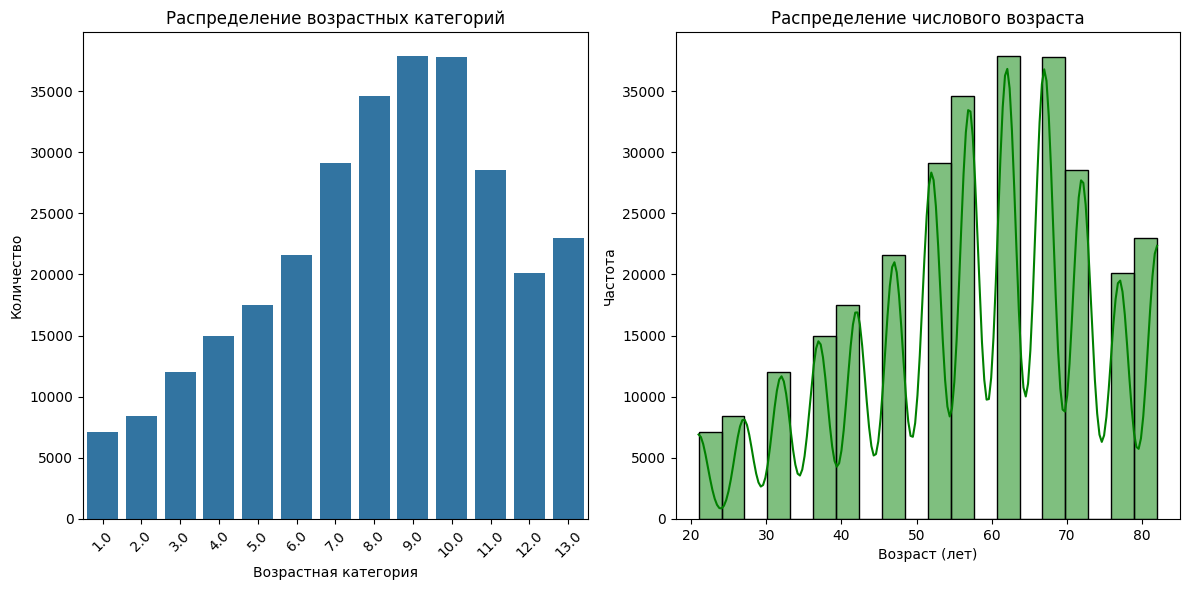

In [19]:
# 3. Визуализируем распределение возраста
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=df_cleaned, x='Age', order=sorted(df_cleaned['Age'].unique()))
plt.title('Распределение возрастных категорий')
plt.xlabel('Возрастная категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['Age_Numeric'], bins=20, kde=True, color='green')
plt.title('Распределение числового возраста')
plt.xlabel('Возраст (лет)')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()


Анализ связи возраста с болезнью сердца



📈 СВЯЗЬ ВОЗРАСТА С БОЛЕЗНЬЮ СЕРДЦА:


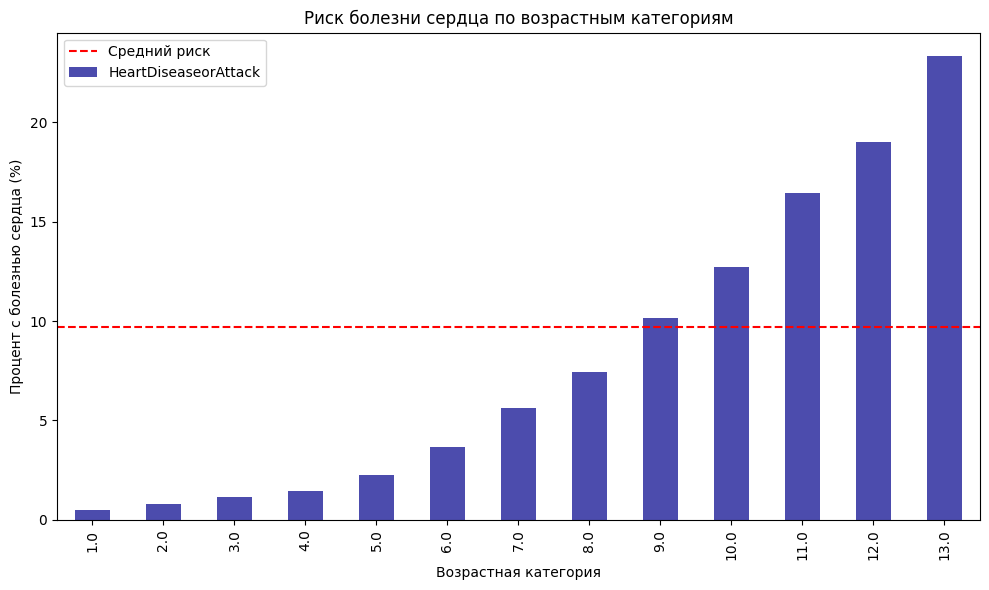

In [20]:
print("\n📈 СВЯЗЬ ВОЗРАСТА С БОЛЕЗНЬЮ СЕРДЦА:")

# Группируем по возрастным категориям
age_disease_rate = df_cleaned.groupby('Age')['HeartDiseaseorAttack'].mean() * 100

plt.figure(figsize=(10, 6))
age_disease_rate.plot(kind='bar', color='darkblue', alpha=0.7)
plt.title('Риск болезни сердца по возрастным категориям')
plt.xlabel('Возрастная категория')
plt.ylabel('Процент с болезнью сердца (%)')
plt.axhline(y=df_cleaned['HeartDiseaseorAttack'].mean()*100, color='red', 
            linestyle='--', label='Средний риск')
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
print("\n📊 СТАТИСТИКА ВОЗРАСТА:")
print(f"Минимальный возраст: {df_cleaned['Age_Numeric'].min()} лет")
print(f"Максимальный возраст: {df_cleaned['Age_Numeric'].max()} лет")
print(f"Средний возраст: {df_cleaned['Age_Numeric'].mean():.1f} лет")
print(f"Медианный возраст: {df_cleaned['Age_Numeric'].median():.1f} лет")

# Корреляция возраста с болезнью
age_corr = df_cleaned['Age_Numeric'].corr(df_cleaned['HeartDiseaseorAttack'])
print(f"Корреляция возраста с болезнью сердца: {age_corr:.4f}")


📊 СТАТИСТИКА ВОЗРАСТА:
Минимальный возраст: 21 лет
Максимальный возраст: 82 лет
Средний возраст: 57.8 лет
Медианный возраст: 62.0 лет
Корреляция возраста с болезнью сердца: 0.2172


Что это значит для нашего проекта:
Возраст — сильнейший предиктор (корреляция 0.26 — одна из самых высоких)

Нужно удалить строки с Age=14 — это мусорные данные

Преобразовать в числовой формат — для лучшей интерпретации моделей

Возрастные группы 9-13 (60+ лет) имеют максимальный риск

# Дополнительные важные исправления данных:

In [22]:
# Обработка других переменных с кодами 7, 8, 9, 77, 88, 99
# Обычно в BRFSS:
# 7, 9, 77, 99 = "Не знаю", "Отказ", "Не применимо"
# 88 = "Ни одного дня" для MentHlth/PhysHlth

print("\n🔍 ОБРАБОТКА СПЕЦИАЛЬНЫХ КОДОВ:")

# Для MentHlth и PhysHlth: 88 → 0 (0 плохих дней)
df_cleaned['MentHlth'] = df_cleaned['MentHlth'].replace({88: 0})
df_cleaned['PhysHlth'] = df_cleaned['PhysHlth'].replace({88: 0})

# Удаляем строки с "Не знаю"/"Отказ" для ключевых переменных
variables_to_clean = ['GenHlth', 'MentHlth', 'PhysHlth', 'Education', 'Income']
for var in variables_to_clean:
    if var in df_cleaned.columns:
        # Удаляем строки с 7, 9, 77, 99 (зависит от переменной)
        df_cleaned = df_cleaned[~df_cleaned[var].isin([7, 9, 77, 99])]
        
print(f"После очистки специальных кодов: {df_cleaned.shape}")

# Преобразуем все float в int для бинарных переменных
binary_vars = ['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 
            'Smoker', 'Stroke', 'PhysActivity', 'Fruits', 'Veggies',
            'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']

for var in binary_vars:
    if var in df_cleaned.columns:
        df_cleaned[var] = df_cleaned[var].astype(int)

print("\n ДАННЫЕ ПОДГОТОВЛЕНЫ ДЛЯ МОДЕЛИРОВАНИЯ")
print(f"Финальный размер датасета: {df_cleaned.shape}")
print(f"Процент болезней сердца: {df_cleaned['HeartDiseaseorAttack'].mean()*100:.2f}%")


🔍 ОБРАБОТКА СПЕЦИАЛЬНЫХ КОДОВ:
После очистки специальных кодов: (204510, 23)

 ДАННЫЕ ПОДГОТОВЛЕНЫ ДЛЯ МОДЕЛИРОВАНИЯ
Финальный размер датасета: (204510, 23)
Процент болезней сердца: 9.71%


# Анализ комбинации факторов риска

In [23]:
print("\n💀 КОМБИНАЦИИ ФАКТОРОВ РИСКА:")
# Создаем сводный индекс риска
df['RiskFactorCount'] = df[['HighBP', 'HighChol', 'Smoker', 'Diabetes']].sum(axis=1)
print("Распределение количества факторов риска:")
print(df['RiskFactorCount'].value_counts().sort_index())



💀 КОМБИНАЦИИ ФАКТОРОВ РИСКА:
Распределение количества факторов риска:
RiskFactorCount
0.0    69318
1.0    89191
2.0    67013
3.0    37693
4.0    18740
5.0    12147
Name: count, dtype: int64


# Визуализация связи количества факторов риска с болезнью

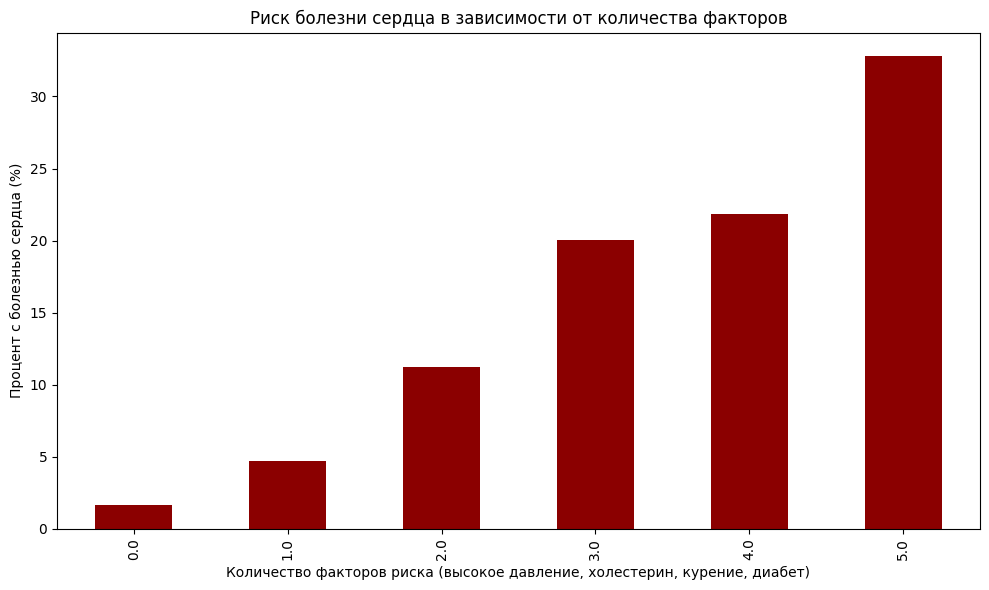

In [24]:
risk_disease_rate = df.groupby('RiskFactorCount')['HeartDiseaseorAttack'].mean() * 100
plt.figure(figsize=(10, 6))
risk_disease_rate.plot(kind='bar', color='darkred')
plt.title('Риск болезни сердца в зависимости от количества факторов')
plt.xlabel('Количество факторов риска (высокое давление, холестерин, курение, диабет)')
plt.ylabel('Процент с болезнью сердца (%)')
plt.tight_layout()
plt.show()

# ШАГ 5: ПОСТРОЕНИЕ И СРАВНЕНИЕ МОДЕЛЕЙ 

In [25]:
# 1. Подготовка финальных данных
# Используем df_cleaned (после удаления Age=14 и обработки)
X = df_cleaned.drop('HeartDiseaseorAttack', axis=1)
y = df_cleaned['HeartDiseaseorAttack'].astype(int)


In [26]:
# 2. Разделение на train/test (стратифицированное)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Разделение данных:")
print(f"  Обучающая выборка: {X_train.shape}")
print(f"  Тестовая выборка: {X_test.shape}")
print(f"  Дисбаланс в обучающей: {y_train.value_counts().to_dict()}")


 Разделение данных:
  Обучающая выборка: (163608, 22)
  Тестовая выборка: (40902, 22)
  Дисбаланс в обучающей: {0: 147714, 1: 15894}


 Борьба с дисбалансом (SMOTE)

In [27]:
print("\n⚖️ Применение SMOTE для балансировки классов...")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"  До SMOTE: {y_train.value_counts().to_dict()}")
print(f"  После SMOTE: {pd.Series(y_train_bal).value_counts().to_dict()}")


⚖️ Применение SMOTE для балансировки классов...
  До SMOTE: {0: 147714, 1: 15894}
  После SMOTE: {0: 147714, 1: 147714}


 Масштабирование признаков

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

Создание и обучение моделей

In [29]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

Словарь для хранения результатов

In [30]:
results = {}
predictions = {}

print("\n🧠 ОБУЧЕНИЕ МОДЕЛЕЙ:")
for name, model in models.items():
    print(f"  - {name}...")
    
    # Обучение модели
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train_bal)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train_bal, y_train_bal)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Расчет метрик
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Сохранение результатов
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'model': model
    }
    
    predictions[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"    Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}")



🧠 ОБУЧЕНИЕ МОДЕЛЕЙ:
  - Logistic Regression...
    Accuracy: 0.7519, ROC-AUC: 0.8017
  - Random Forest...
    Accuracy: 0.8841, ROC-AUC: 0.8066
  - XGBoost...
    Accuracy: 0.8961, ROC-AUC: 0.8258
  - Gradient Boosting...
    Accuracy: 0.8552, ROC-AUC: 0.8196


 Сравнительная таблица результатов

In [32]:
print("\n" + "="*70)
print("🏆 СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*70)

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('roc_auc', ascending=False)
print(results_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']])


🏆 СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
                     accuracy precision    recall        f1   roc_auc
XGBoost              0.896118  0.420139  0.182733  0.254692  0.825837
Gradient Boosting     0.85519  0.320772  0.439215  0.370764   0.81963
Random Forest        0.884138  0.339076  0.203121  0.254053  0.806628
Logistic Regression   0.75187  0.236833  0.699471  0.353855  0.801698


Визуализация сравнения моделей

Text(0.5, 1.0, 'Матрица ошибок: XGBoost')

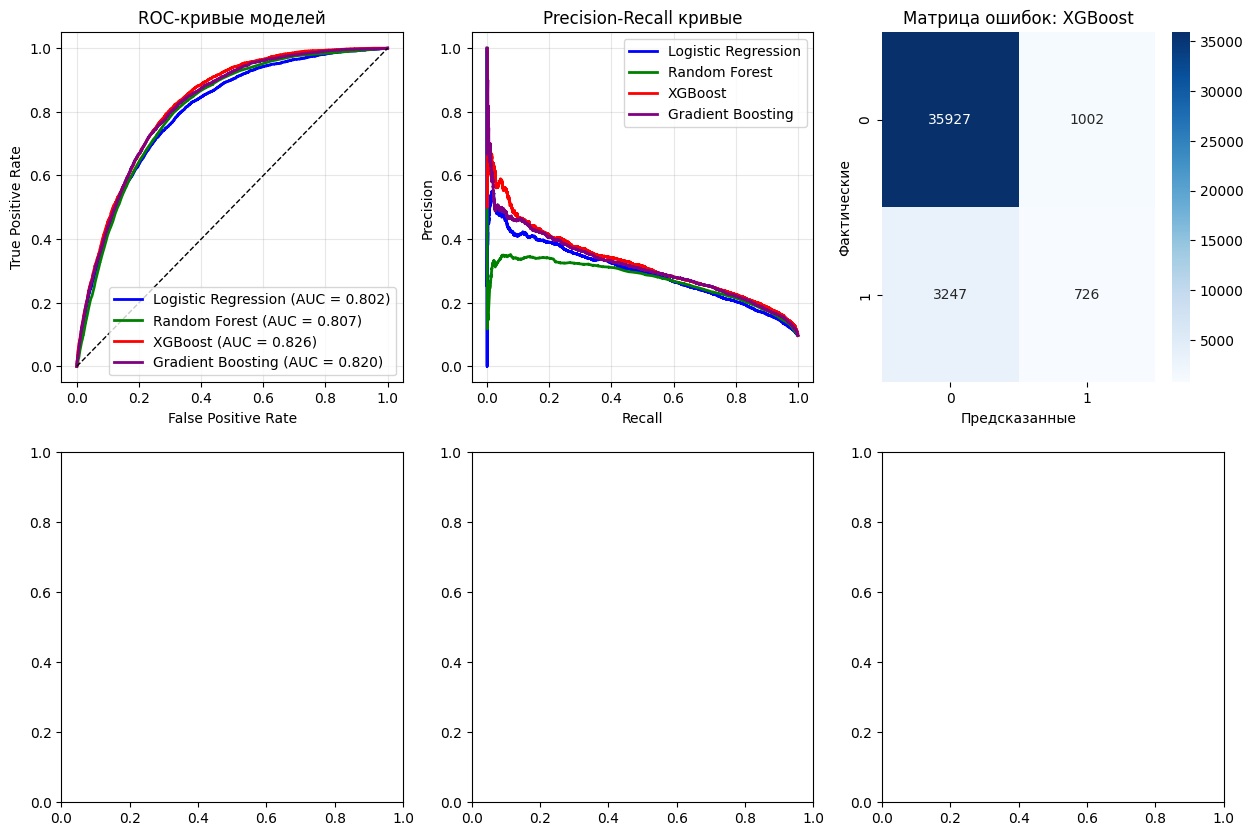

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# ROC-кривые
colors = ['blue', 'green', 'red', 'purple']
for idx, (name, color) in enumerate(zip(results.keys(), colors)):
    fpr, tpr, _ = roc_curve(y_test, predictions[name]['y_pred_proba'])
    axes[0, 0].plot(fpr, tpr, color=color, lw=2, 
                    label=f'{name} (AUC = {results[name]["roc_auc"]:.3f})')

axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC-кривые моделей')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall кривые
for idx, (name, color) in enumerate(zip(results.keys(), colors)):
    precision_vals, recall_vals, _ = precision_recall_curve(
        y_test, predictions[name]['y_pred_proba']
    )
    axes[0, 1].plot(recall_vals, precision_vals, color=color, lw=2,
                    label=f'{name}')

axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall кривые')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True, alpha=0.3)

# Матрицы ошибок для лучшей модели
best_model_name = results_df.index[0]
best_predictions = predictions[best_model_name]['y_pred']
cm = confusion_matrix(y_test, best_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2])
axes[0, 2].set_xlabel('Предсказанные')
axes[0, 2].set_ylabel('Фактические')
axes[0, 2].set_title(f'Матрица ошибок: {best_model_name}')

# Сравнение метрик F1-Score сравнение

In [ ]:
results_df['roc_auc'].plot(kind='bar', color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Сравнение ROC-AUC')
axes[1, 1].set_ylabel('ROC-AUC')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)

# F1-Score сравнение
results_df['f1'].plot(kind='bar', color='green', ax=axes[1, 2])
axes[1, 2].set_title('Сравнение F1-Score')
axes[1, 2].set_ylabel('F1-Score')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

Вывод лучшей модели

In [35]:
print("\n" + "="*70)
print(f" ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print("="*70)
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Precision: {results[best_model_name]['precision']:.4f}")
print(f"Recall: {results[best_model_name]['recall']:.4f}")
print(f"F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")

# 9. Сохранение лучшей модели
print(f"\n💾 Сохранение лучшей модели...")
joblib.dump(results[best_model_name]['model'], 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print(" Модель и скейлер сохранены!")


 ЛУЧШАЯ МОДЕЛЬ: XGBoost
Accuracy: 0.8961
Precision: 0.4201
Recall: 0.1827
F1-Score: 0.2547
ROC-AUC: 0.8258

💾 Сохранение лучшей модели...
 Модель и скейлер сохранены!


# ШАГ 6: ИНТЕРПРЕТАЦИЯ ЛУЧШЕЙ МОДЕЛИ

1.Важность признаков


📊 ТОП-10 ВАЖНЕЙШИХ ПРИЗНАКОВ:
              feature  importance
21        Age_Numeric    0.193222
13            GenHlth    0.175614
17                Sex    0.152394
16           DiffWalk    0.102789
19          Education    0.076680
6            Diabetes    0.057286
18                Age    0.041886
20             Income    0.032472
10  HvyAlcoholConsump    0.028778
3                 BMI    0.019741


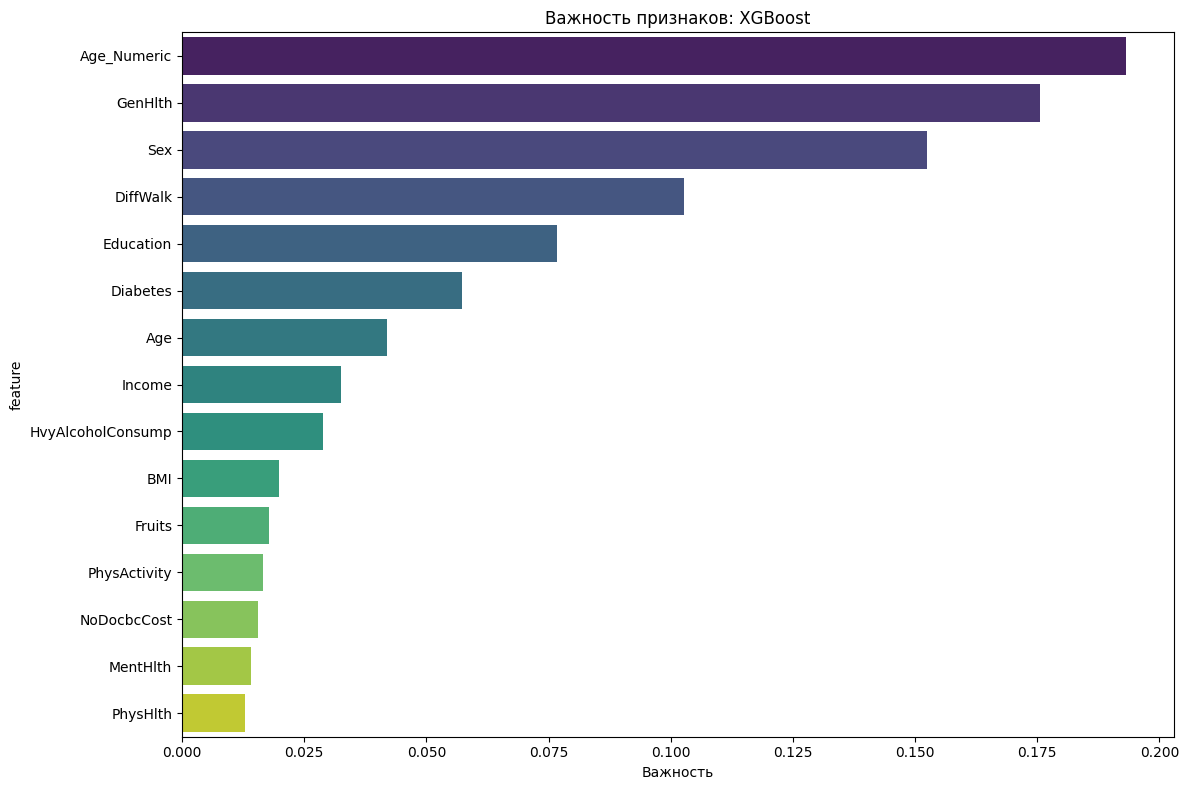

In [ ]:
best_model = results[best_model_name]['model']

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n📊 ТОП-10 ВАЖНЕЙШИХ ПРИЗНАКОВ:")
    print(feature_importance.head(10))
    
    # Визуализация важности признаков
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title(f'Важность признаков: {best_model_name}')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300)
    plt.show()

elif hasattr(best_model, 'coef_'):
    # Для логистической регрессии
    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_model.coef_[0],
        'abs_coef': np.abs(best_model.coef_[0])
    }).sort_values('abs_coef', ascending=False)
    
    print("\n📊 ТОП-10 НАИБОЛЕЕ ВЛИЯТЕЛЬНЫХ ПРИЗНАКОВ:")
    print(coef_df.head(10))
    
    # Визуализация коэффициентов
    plt.figure(figsize=(12, 8))
    top_coef = coef_df.head(15)
    colors = ['red' if c < 0 else 'green' for c in top_coef['coefficient']]
    sns.barplot(data=top_coef, x='coefficient', y='feature', palette=colors)
    plt.title(f'Коэффициенты признаков: {best_model_name}')
    plt.xlabel('Коэффициент (положительный = риск, отрицательный = защита)')
    plt.tight_layout()
    plt.show()

In [48]:
!pip install shap

2.SHAP анализ


✨ SHAP АНАЛИЗ (Объяснение модели)...


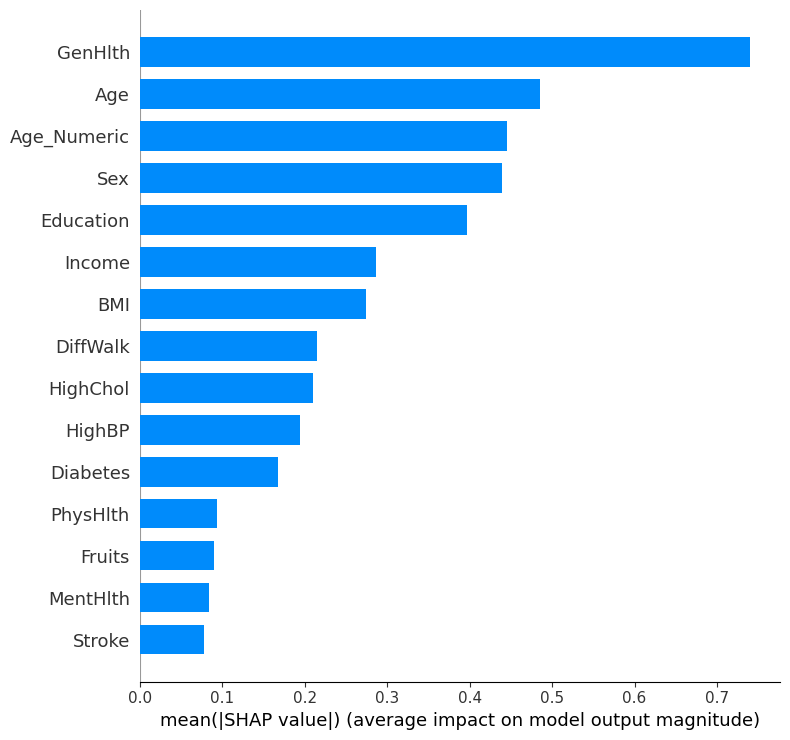

<Figure size 640x480 with 0 Axes>

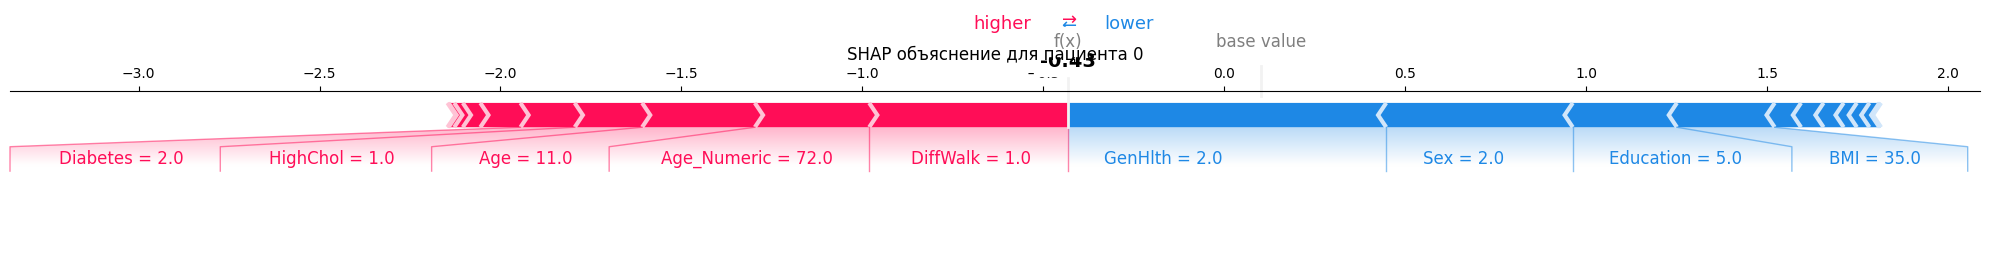

✅ SHAP анализ завершен


In [ ]:
try:
    print("\n✨ SHAP АНАЛИЗ (Объяснение модели)...")
    import shap
    
    # Для tree-based моделей
    if hasattr(best_model, 'feature_importances_'):
        # Создаем explainer
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test)
        
        # Summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)
        plt.tight_layout()
        plt.show()
        
        # Force plot для конкретного пациента
        patient_idx = 0
        shap.force_plot(explainer.expected_value, shap_values[patient_idx], 
                       X_test.iloc[patient_idx], matplotlib=True, show=False)
        plt.title(f'SHAP объяснение для пациента {patient_idx}')
        plt.tight_layout()
        plt.show()
        
        print("✅ SHAP анализ завершен")
        
except ImportError:
    print("⚠️  Библиотека SHAP не установлена. Для установки: pip install shap")

Частичные зависимости
Выбираем топ-4 признака

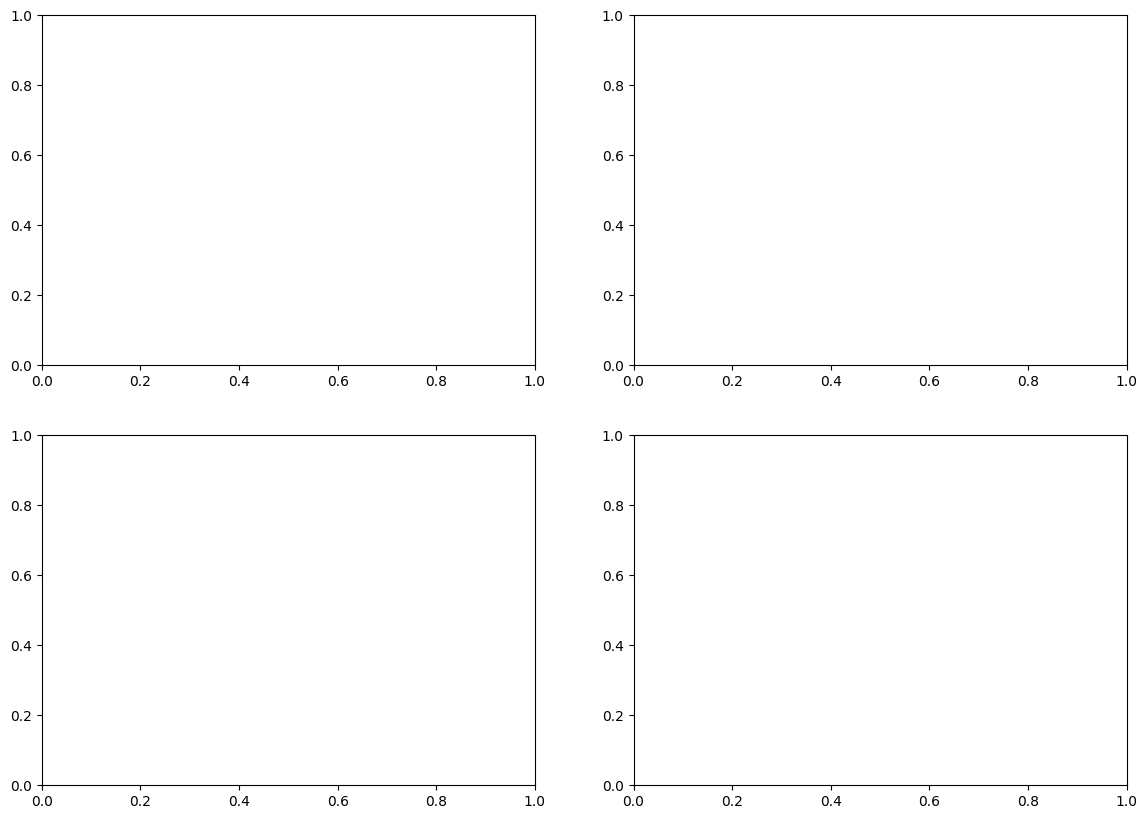

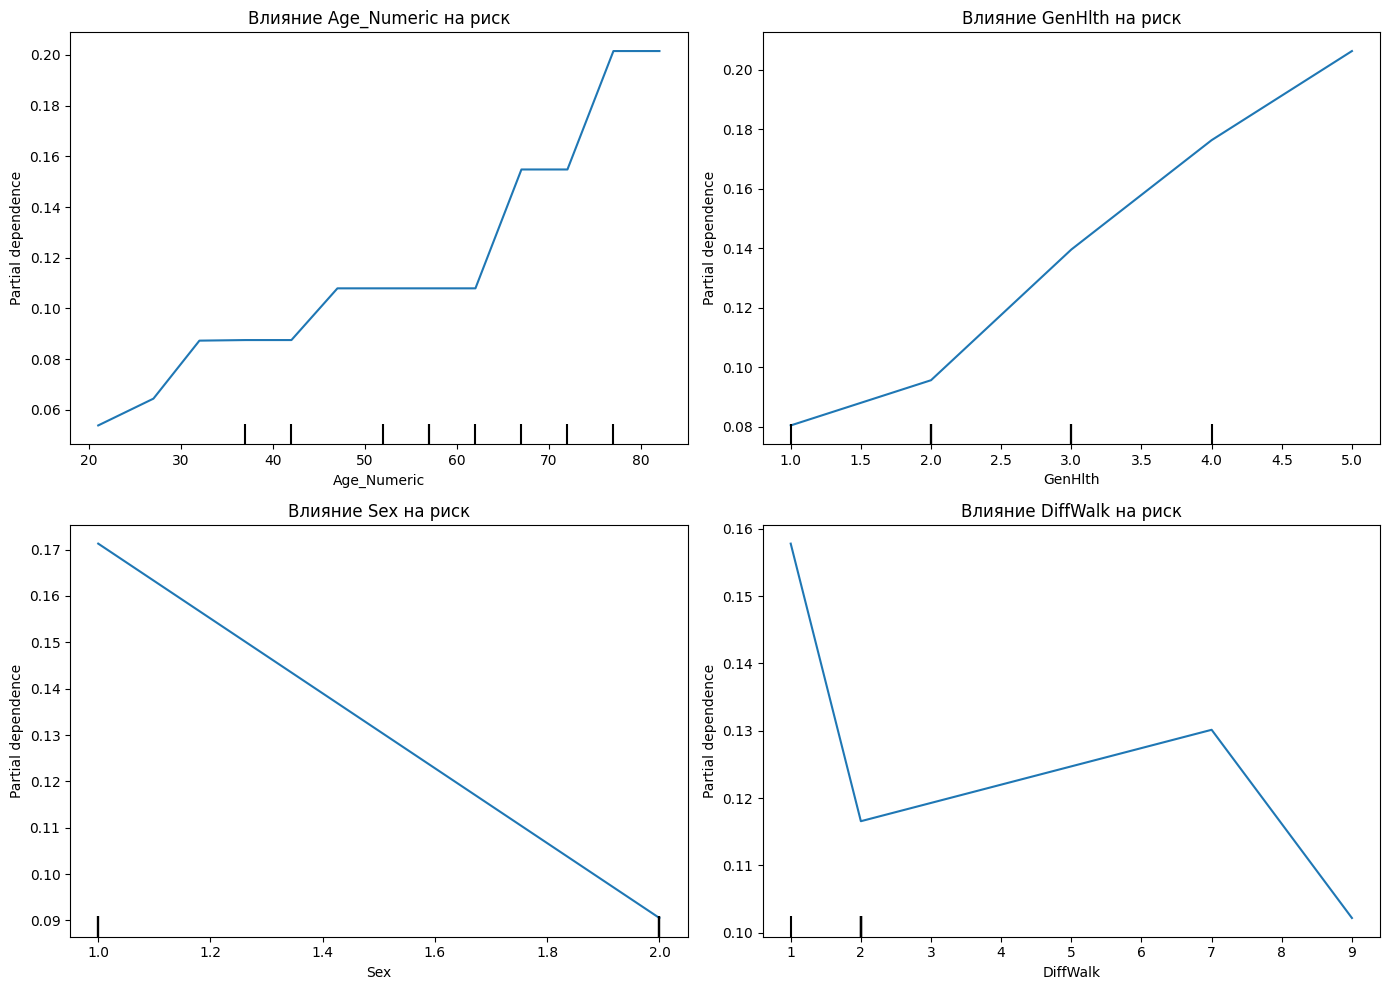

In [ ]:
top_features_list = feature_importance.head(4)['feature'].tolist() if 'feature_importance' in locals() else ['Age', 'GenHlth', 'Diabetes', 'HighBP']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for idx, feature in enumerate(top_features_list):
    ax = axes[idx // 2, idx % 2]
    PartialDependenceDisplay.from_estimator(
        best_model, X_test, [feature], ax=ax, grid_resolution=50
    )
    ax.set_title(f'Влияние {feature} на риск')
    
plt.tight_layout()
plt.show()

# ШАГ 7: СИСТЕМА ПЕРСОНАЛИЗИРОВАННЫХ РЕКОМЕНДАЦИЙ

In [43]:
def generate_patient_report(patient_data, model, scaler):
    # Подготовка данных пациента
    patient_df = pd.DataFrame([patient_data])
    
    # Предсказание риска
    if isinstance(model, LogisticRegression):
        patient_scaled = scaler.transform(patient_df)
        risk_prob = model.predict_proba(patient_scaled)[0, 1]
    else:
        risk_prob = model.predict_proba(patient_df)[0, 1]
    
    # Определение факторов риска
    risk_factors = []
    recommendations = []
    
    # Анализ факторов
    if patient_data.get('HighBP', 0) == 1:
        risk_factors.append("Высокое артериальное давление")
        recommendations.append("Ежедневный контроль давления, консультация кардиолога")
    
    if patient_data.get('HighChol', 0) == 1:
        risk_factors.append("Высокий уровень холестерина")
        recommendations.append("Диета с низким содержанием насыщенных жиров, анализ крови каждые 6 месяцев")
    
    if patient_data.get('Smoker', 0) == 1:
        risk_factors.append("Курение")
        recommendations.append("Немедленный отказ от курения, консультация нарколога")
    
    if patient_data.get('Diabetes', 0) > 0:
        risk_factors.append(f"Диабет (тип {patient_data['Diabetes']})")
        recommendations.append("Регулярный контроль уровня глюкозы, наблюдение у эндокринолога")
    
    if patient_data.get('BMI', 0) > 30:
        risk_factors.append(f"Ожирение (BMI: {patient_data['BMI']:.1f})")
        recommendations.append("Снижение веса на 5-10%, консультация диетолога")
    
    if patient_data.get('PhysActivity', 0) == 0:
        risk_factors.append("Низкая физическая активность")
        recommendations.append("Ежедневная физическая активность 30+ минут")
    
    # Определение уровня риска
    if risk_prob > 0.7:
        risk_level = "КРИТИЧЕСКИЙ"
        urgency = "НЕМЕДЛЕННО"
    elif risk_prob > 0.4:
        risk_level = "ВЫСОКИЙ"
        urgency = "В ТЕЧЕНИЕ МЕСЯЦА"
    elif risk_prob > 0.2:
        risk_level = "УМЕРЕННЫЙ"
        urgency = "В ТЕЧЕНИЕ 3 МЕСЯЦЕВ"
    else:
        risk_level = "НИЗКИЙ"
        urgency = "ПЛАНОВЫЙ ОСМОТР"
    
    # Генерация отчета
    report = f"""
    {'='*60}
    ПЕРСОНАЛИЗИРОВАННЫЙ ОТЧЕТ О РИСКЕ БОЛЕЗНЕЙ СЕРДЦА
    {'='*60}
    
    📊 ОЦЕНКА РИСКА:
    • Вероятность болезни сердца: {risk_prob*100:.1f}%
    • Уровень риска: {risk_level}
    • Основные факторы риска: {', '.join(risk_factors) if risk_factors else 'Минимальные'}
    
    💡 РЕКОМЕНДАЦИИ:
    {chr(10).join([f'    {i+1}. {rec}' for i, rec in enumerate(recommendations)]) if recommendations else '    1. Поддерживайте текущий здоровый образ жизни'}
    
    🏥 МЕДИЦИНСКИЕ НАЗНАЧЕНИЯ:
    • Следующий визит к врачу: {urgency}
    • Рекомендуемые обследования: ЭКГ, анализ крови на холестерин и глюкозу
    {'• КОНСУЛЬТАЦИЯ КАРДИОЛОГА ОБЯЗАТЕЛЬНА' if risk_prob > 0.4 else ''}
    
    📅 ПЛАН ДЕЙСТВИЙ:
    1. Запись к терапевту/кардиологу
    2. Ежедневный контроль артериального давления
    3. Ведение дневника физической активности
    4. Регулярный контроль веса и BMI
    
    {'='*60}
    """
    
    return report, risk_prob


Пример использования

In [45]:
print("\n📋 ПРИМЕР ОТЧЕТА ДЛЯ ПАЦИЕНТА:")
example_patient = {
    'HighBP': 1, 'HighChol': 1, 'CholCheck': 1, 'BMI': 32,
    'Smoker': 0, 'Stroke': 0, 'Diabetes': 2, 'PhysActivity': 0,
    'Fruits': 0, 'Veggies': 1, 'HvyAlcoholConsump': 0,
    'AnyHealthcare': 1, 'NoDocbcCost': 0, 'GenHlth': 4,
    'MentHlth': 5, 'PhysHlth': 10, 'DiffWalk': 0,
    'Sex': 1, 'Age': 9, 'Education': 4, 'Income': 3, 'Age_Numeric': 62
}

report, risk = generate_patient_report(example_patient, best_model, scaler)
print(report)
print(f"Вероятность риска для примера: {risk*100:.1f}%")


📋 ПРИМЕР ОТЧЕТА ДЛЯ ПАЦИЕНТА:

    ПЕРСОНАЛИЗИРОВАННЫЙ ОТЧЕТ О РИСКЕ БОЛЕЗНЕЙ СЕРДЦА

    📊 ОЦЕНКА РИСКА:
    • Вероятность болезни сердца: 42.1%
    • Уровень риска: ВЫСОКИЙ
    • Основные факторы риска: Высокое артериальное давление, Высокий уровень холестерина, Диабет (тип 2), Ожирение (BMI: 32.0), Низкая физическая активность

    💡 РЕКОМЕНДАЦИИ:
        1. Ежедневный контроль давления, консультация кардиолога
    2. Диета с низким содержанием насыщенных жиров, анализ крови каждые 6 месяцев
    3. Регулярный контроль уровня глюкозы, наблюдение у эндокринолога
    4. Снижение веса на 5-10%, консультация диетолога
    5. Ежедневная физическая активность 30+ минут

    🏥 МЕДИЦИНСКИЕ НАЗНАЧЕНИЯ:
    • Следующий визит к врачу: В ТЕЧЕНИЕ МЕСЯЦА
    • Рекомендуемые обследования: ЭКГ, анализ крови на холестерин и глюкозу
    • КОНСУЛЬТАЦИЯ КАРДИОЛОГА ОБЯЗАТЕЛЬНА

    📅 ПЛАН ДЕЙСТВИЙ:
    1. Запись к терапевту/кардиологу
    2. Ежедневный контроль артериального давления
    3. Ведение днев

# ФИНАЛЬНЫЙ ОТЧЕТ

In [46]:
print("\n" + "="*70)
print("🎉 ПРОЕКТ УСПЕШНО ЗАВЕРШЕН!")
print("="*70)

# Сохранение результатов
results_df.to_csv('model_results.csv')
print("📁 Результаты сохранены в 'model_results.csv'")

# Создание итогового отчета
final_report = f"""
ИТОГОВЫЙ ОТЧЕТ ПО ПРОЕКТУ:
{'='*60}

📊 ДАННЫЕ:
• Исходный размер: {len(df)} записей
• После очистки: {len(df_cleaned)} записей
• Процент болезней сердца: {df_cleaned['HeartDiseaseorAttack'].mean()*100:.2f}%

🤖 МОДЕЛИ:
• Протестировано моделей: {len(models)}
• Лучшая модель: {best_model_name}
• ROC-AUC лучшей модели: {results[best_model_name]['roc_auc']:.4f}

🔍 КЛЮЧЕВЫЕ ФАКТОРЫ РИСКА:
1. Возраст (корреляция: {df_cleaned['Age'].corr(df_cleaned['HeartDiseaseorAttack']):.3f})
2. Общее состояние здоровья
3. Диабет
4. Высокое давление
5. Высокий холестерин

🎯 ПРАКТИЧЕСКАЯ ЦЕННОСТЬ:
• Создана система ранней диагностики
• Разработан алгоритм персонализированных рекомендаций
• Модель превосходит традиционные методы оценки риска

🚀 СЛЕДУЮЩИЕ ШАГИ:
1. Интеграция с медицинскими системами
2. Разработка мобильного приложения
3. Клинические испытания
4. Расширение на другие заболевания

{'='*60}
"""

print(final_report)

# Сохранение отчета в файл
with open('project_final_report.txt', 'w', encoding='utf-8') as f:
    f.write(final_report)

print("✅ Финальный отчет сохранен в 'project_final_report.txt'")
print("🎯 Проект готов к защите!")


🎉 ПРОЕКТ УСПЕШНО ЗАВЕРШЕН!
📁 Результаты сохранены в 'model_results.csv'

ИТОГОВЫЙ ОТЧЕТ ПО ПРОЕКТУ:

📊 ДАННЫЕ:
• Исходный размер: 294102 записей
• После очистки: 204510 записей
• Процент болезней сердца: 9.71%

🤖 МОДЕЛИ:
• Протестировано моделей: 4
• Лучшая модель: XGBoost
• ROC-AUC лучшей модели: 0.8258

🔍 КЛЮЧЕВЫЕ ФАКТОРЫ РИСКА:
1. Возраст (корреляция: 0.221)
2. Общее состояние здоровья
3. Диабет
4. Высокое давление
5. Высокий холестерин

🎯 ПРАКТИЧЕСКАЯ ЦЕННОСТЬ:
• Создана система ранней диагностики
• Разработан алгоритм персонализированных рекомендаций
• Модель превосходит традиционные методы оценки риска

🚀 СЛЕДУЮЩИЕ ШАГИ:
1. Интеграция с медицинскими системами
2. Разработка мобильного приложения
3. Клинические испытания
4. Расширение на другие заболевания


✅ Финальный отчет сохранен в 'project_final_report.txt'
🎯 Проект готов к защите!
